# Random Forests: Parameter Tuning

- n_estimators: The number of trees in the forest. Choose as high as possible by your computer. Literally.
- max_features: The number of features to consider while looking for the best split. Try 'auto', none, sqrt, log2, 0.9, and 0.2.
- min_samples_leaf: The minimum number of samples in newly created leaves. Try 1,2,3 BUT if 3 is the best, try higher.

In [1]:
# With the goal above, I will import just what I need. 
# The model to use (I already imported it above, but will do it again here so each example is self-contained)
from sklearn.ensemble import RandomForestRegressor

# The error metric. In this case, we will use c-stat (aka ROC/AUC)
from sklearn.metrics import roc_auc_score

# An efficient data structure. 
import pandas as pd

%pylab inline

# Import the data
X = pd.read_csv("../data/train.csv")
y = X.pop("Survived")

Populating the interactive namespace from numpy and matplotlib


In [2]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
# Impute Age with mean
X["Age"].fillna(X.Age.mean(), inplace=True)

# Confirm the code is correct
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
# Get just the numeric variables by selecting only the variables that are not "object" datatypes.
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_variables].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


In [5]:
# Let's build our first model. I always have oob_score=True. It is a good idea to increase n_estimators to a number higher than 
# the default. In this case the oob_predictions will be based on a forest of 33 trees. I set random_state=42 so that you all can
# replicate the model exactly.
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)

# I only use numeric_variables because I have yet to dummy out the categorical variables
model.fit(X[numeric_variables], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [6]:
# For regression, the oob_score_ attribute gives the R^2 based on the oob predictions. We want to use c-stat, but I mention this 
# for awareness. By the way, attributes in sklearn that have a trailing underscore are only available after the model has been fit.
model.oob_score_

0.1361695005913669

In [7]:
y_oob = model.oob_prediction_
print("c-stat: ", roc_auc_score(y, y_oob))

c-stat:  0.73995515504


In [8]:
# Here is a simple function to show descriptive stats on the categorical variables
def describe_categorical(X):
    """
    Just like .describe(), but returns the results for
    categorical variables only.
    """
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [9]:
describe_categorical(X)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Greenfield, Mr. William Bertram",male,347082,G6,S
freq,1,577,7,4,644


In [10]:
# Drop the variables I don't feel like dealing with for this tutorial
X.drop(["Name", "Ticket", "PassengerId"], axis=1, inplace=True)

In [11]:
# Change the Cabin variable to be only the first letter or None
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return "None"

X["Cabin"] = X.Cabin.apply(clean_cabin)

In [12]:
categorical_variables = ['Sex', 'Cabin', 'Embarked']

for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [13]:
X

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.000000,0,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
5,3,29.699118,0,0,8.4583,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
6,1,54.000000,0,0,51.8625,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
7,3,2.000000,3,1,21.0750,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
8,3,27.000000,0,2,11.1333,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
9,2,14.000000,1,0,30.0708,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [14]:
# Look at all the columns in the dataset
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))
    
printall(X)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.000000,0,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
887,1,19.000000,0,0,30.0000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
888,3,29.699118,1,2,23.4500,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
889,1,26.000000,0,0,30.0000,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [15]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)
print ("C-stat: ", roc_auc_score(y, model.oob_prediction_))

C-stat:  0.863521128261


### Variable importance measures

In [16]:
model.feature_importances_

array([  9.11384671e-02,   2.38891052e-01,   4.43567267e-02,
         2.15831071e-02,   2.15047796e-01,   1.43423437e-01,
         1.58822440e-01,   2.95342368e-03,   3.79055011e-03,
         6.47116172e-03,   4.30998991e-03,   8.59480266e-03,
         1.02403226e-03,   8.12054428e-04,   2.67741854e-02,
         6.64265010e-05,   1.06189189e-02,   0.00000000e+00,
         6.00379221e-03,   1.53176370e-02])

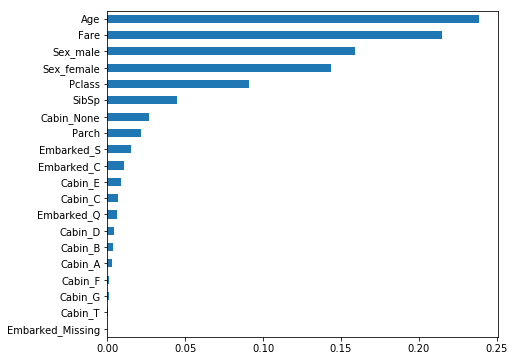

In [17]:
# Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(7,6));

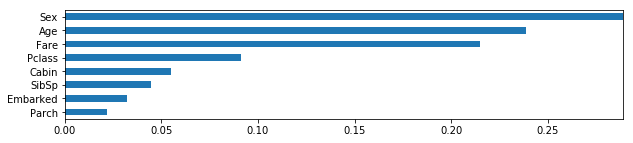

In [18]:
# Complex version that shows the summary view

-

## Parameters Improving Performance:

 * ### Parameters that will make your model better
  * <b>n_estimators</b>: The number of trees in the forest. Choose as high of a number as your computer can handle.
  * <b>max_features</b>: The number of features to consider when looking for the best split. Try ["auto", "None", "sqrt", "log2", 0.9, and 0.2]
  * <b>min_samples_leaf</b>: The minimum number of samples in newly created leaves.Try [1, 2, 3]. If 3 is the best, try higher numbers such as 1 through 10.
 * ### Parameters that will make it easier to train your model
  * <b>n_jobs</b>: Determines if multiple processors should be used to train and test the model. Always set this to -1 and %%timeit vs. if it is set to 1. It should be much faster (especially when many trees are trained).

## n_jobs

In [19]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=42)
model.fit(X, y)

1 loop, best of 3: 1.88 s per loop


In [20]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)

1 loop, best of 3: 1.47 s per loop


## n_estimators

30 trees
C-stat:  0.853870407652

50 trees
C-stat:  0.860698345743

100 trees
C-stat:  0.863521128261

200 trees
C-stat:  0.862192290076

500 trees
C-stat:  0.863739494456

1000 trees
C-stat:  0.864043076726

2000 trees
C-stat:  0.863449227197



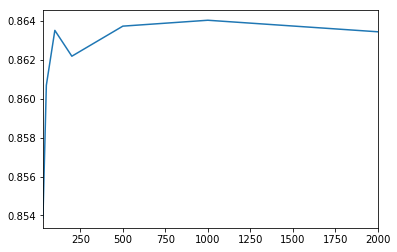

In [21]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X, y)
    print (trees, "trees")
    roc = roc_auc_score(y, model.oob_prediction_)
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, n_estimator_options).plot();

### max_features

auto option
C-stat:  0.864043076726

None option
C-stat:  0.864043076726

sqrt option
C-stat:  0.86337466313

log2 option
C-stat:  0.86337466313

0.9 option
C-stat:  0.863534443273

0.2 option
C-stat:  0.86337466313



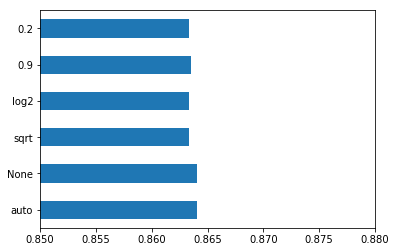

In [22]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X, y)
    print (max_features, "option")
    roc = roc_auc_score(y, model.oob_prediction_)
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, max_features_options).plot(kind="barh", xlim=(.85,.88));

### min_samples_leaf

1 min samples
C-stat:  0.864043076726

2 min samples
C-stat:  0.869654022731

3 min samples
C-stat:  0.871571384442

4 min samples
C-stat:  0.873478094142

5 min samples
C-stat:  0.874269005848

6 min samples
C-stat:  0.874029335634

7 min samples
C-stat:  0.873304998988

8 min samples
C-stat:  0.871866977705

9 min samples
C-stat:  0.869294517411

10 min samples
C-stat:  0.867430415748



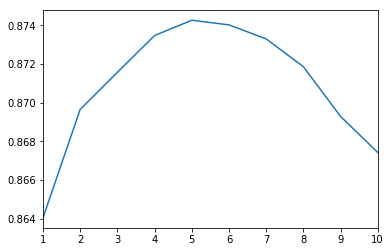

In [23]:
results = []
min_samples_split_options = [3,5,7]

for min_samples_splitt in min_samples_split_options:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto", 
                                  min_samples_leaf=2,
                                 min_samples_split=min_samples_splitt)
    model.fit(X, y)
    print (min_samples, "min samples")
    roc = roc_auc_score(y, model.oob_prediction_)
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, min_samples_leaf_options).plot();

## Final Model

In [24]:
model = RandomForestRegressor(n_estimators=2000, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features="sqrt", 
                              min_samples_leaf=1)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print ("C-stat: ", roc)

C-stat:  0.874269005848
